## <p style="text-align: center;">Numerical Algorithms - Homework Assignment 3</p>
**<p style="text-align: center;">VU Numerical Algorithms, summer semester 2018. Due to 17.06.2018. </p>**

### Programming Exercises

#### Effects of Preconditioners on Conjugate Gradient (12 points)

Implement the conjugate gradient method *CG* and experimentally investigate the effect of different preconditioners on its convergence. Please compare standard *CG* and preconditioned *CG* (*PCG*) for three given symmetric positive definite test problems in terms of the number of iterations and in terms of the runtime (including the time for
computing and applying the preconditioner!) until convergence. Show the convergence histories (norm of relative residual vs. iteration number) graphically.

* Implement standard CG efficiently (_do not use the CG implementation available in Octave!_). In particular, store the sparse matrix in a sparse matrix format
* Use the following preconditioners:
Diagonal preconditioner
  * Block diagonal preconditioner
  * Incomplete Cholesky factorization with no fill-in
  * Incomplete Cholesky factorization with threshold dropping: experiment with different thresholds and discuss the effect of the choice of threshold.
* Test matrices: Please use (at least) the following three test matrices from the
"Matrix Market" (http://math.nist.gov/MatrixMarket/) for your experiments:
  * http://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lanpro/nos5.html
  * http://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lanpro/nos6.html
  * http://math.nist.gov/MatrixMarket/data/misc/cylshell/s3rmt3m3.html

In [ ]:
%plot -f svg

% Import routines needed to execute assignment.
source("source/assignment3.m")
% Import routines for reading matrix market (.mtx) format.
% Source: https://math.nist.gov/MatrixMarket/mmio/matlab/mmiomatlab.html.
source("source/mminfo.m")
source("source/mmread.m")

% Execute code for programming assignment.
function execute()
    res = struct();
    
    % Iterate over test matrices.
    filenames = {"nos5.mtx"; "nos6.mtx"; "s3rmt3m3.mtx"};
    #fileAlphas = [0 0 774]; % s3: 1032
    fileAlphas = [0 0 2000];
    fileBlocksizes = [2 4 64];
    fileThresholds = [0.2 10 0.2];
    fileMarkerIntervals = [3 3 200];
    
    for i = 1:length(filenames)
        printf("\n%s", filenames{i});
        disp(" ");
        fflush(stdout);
        
        % Load file.
        [A, rows, cols, entries, rep, field, symm] = mmread(["data/" filenames{i}]);

        % Prepare data structure for evaluation metrics.
        res.(filenames{i}).st = struct();
        
        % ----------------------------------------------------
        % 1. Apply standard CG.
        % ----------------------------------------------------
        
        startTime = time();
        [
            res.(filenames{i}).st.numberOfIterations, ...
            res.(filenames{i}).st.runTime, ...
            res.(filenames{i}).st.relativeResidualHistory
        ] = applyCG(A, 10^-3);
        res.(filenames{i}).st.runTime = time() - startTime();
        
        % ----------------------------------------------------
        % 2. Apply CG with preconditioner.
        % ----------------------------------------------------
        
        pcNames = {"cholesky_nofi"; "cholesky_drop"}; #"diag"; "block";
        for j = 1:length(pcNames)
            printf("    %s\n", pcNames{j});
            fflush(stdout);

            res.(filenames{i}).(pcNames{j}) = struct();
            
            % Configure preconditioner.
            % Note: Parameters used here were determined in prior experiments (see documentation).
            precondConfig = struct();
            precondConfig.method = pcNames{j};
            % Set predetermined matrix-specific hyperparameter values.
            precondConfig.alpha = fileAlphas(i);
            precondConfig.stepsize = fileBlocksizes(i);
            precondConfig.dropThreshold = fileThresholds(i);
            
            % Generate matrix for preconditioning.
            M_inv = generatePreconditioning(A, precondConfig);
            
            % Apply CG with preconditioning.
            startTime = time();
            [
                res.(filenames{i}).(pcNames{j}).numberOfIterations, ...
                res.(filenames{i}).(pcNames{j}).runTime, ...
                res.(filenames{i}).(pcNames{j}).relativeResidualHistory
            ] = applyCG(A, 10^-3, M_inv);
            res.(filenames{i}).(pcNames{j}).runTime = time() - startTime();
        end
        
        % ----------------------------------------------------
        % 3. Plot results.
        % ----------------------------------------------------

        % (1) Plot runtimes.
        figure('Position',[0, 0, 500, 250])
        grid on
        bar([
            res.(filenames{i}).st.runTime, 
 %           res.(filenames{i}).diag.runTime,
 %           res.(filenames{i}).block.runTime,
            res.(filenames{i}).cholesky_nofi.runTime,
            res.(filenames{i}).cholesky_drop.runTime
        ]);
        title ([filenames{i} "\nRuntime Until Convergence"], 'fontsize', 16);
        set(gca (), "xtick", [1 2 3 4 5], "xticklabel", {"Standard", "Diagonale", "Block-Diag.", "IC(0)", "ICT. thresh."})
        ylabel('Runtime in seconds'); 
        
        % (2) Plot numbers of iterations.
        figure('Position',[0, 0, 400, 250])
        grid on
        bar([
            res.(filenames{i}).st.numberOfIterations, 
%            res.(filenames{i}).diag.numberOfIterations,
%            res.(filenames{i}).block.numberOfIterations,
            res.(filenames{i}).cholesky_nofi.numberOfIterations,
            res.(filenames{i}).cholesky_drop.numberOfIterations
        ]);
        set(gca (), "xtick", [1 2 3 4 5], "xticklabel", {"Standard", "Diagonale", "Block-Diag.", "IC(0)", "ICT"})
        title ([filenames{i} "\nNumber of Iterations Until Convergence"], 'fontsize', 16);
        ylabel('Number of iterations');         
        
        % (3) Plot relative residual history.
        % Note: Plot only every 5th point for readability.
        figure('Position',[0, 0, 600, 350])
        grid on
        hold on

        semilogy([1:res.(filenames{i}).st.numberOfIterations + 1](1:fileMarkerIntervals(i):end), 
             res.(filenames{i}).st.relativeResidualHistory(1:fileMarkerIntervals(i):end), 
             'markersize', 2, '1; Standard CG;x--');
%        semilogy([1:res.(filenames{i}).diag.numberOfIterations + 1](1:fileMarkerIntervals(i):end), 
%             res.(filenames{i}).diag.relativeResidualHistory(1:fileMarkerIntervals(i):end), 
%             'markersize', 2, '2; CG with diagonale PC;^-');
%        semilogy([1:res.(filenames{i}).block.numberOfIterations + 1](1:fileMarkerIntervals(i):end), 
%             res.(filenames{i}).block.relativeResidualHistory(1:fileMarkerIntervals(i):end), 
%             'markersize', 2, '3; CG with block-diagonale PC;o-');
        semilogy([1:res.(filenames{i}).cholesky_nofi.numberOfIterations + 1](1:fileMarkerIntervals(i):end), 
             res.(filenames{i}).cholesky_nofi.relativeResidualHistory(1:fileMarkerIntervals(i):end), 
             'markersize', 2, '4; CG with IC(0);+-');
        semilogy([1:res.(filenames{i}).cholesky_drop.numberOfIterations + 1](1:fileMarkerIntervals(i):end), 
             res.(filenames{i}).cholesky_drop.relativeResidualHistory(1:fileMarkerIntervals(i):end), 
             'markersize', 2, '5; CG with ICT;*-');
        legend ({
            'Standard CG',
%            'CG with diagonale PC',
%            'CG with block-diagonale PC',
            'CG with IC(0)',
            'CG with ICT'
        })
        title ([filenames{i} "\nRelative Residual Histories"], 'fontsize', 16);
        xlabel('Number of iterations');
        ylabel('Relative residual');  
        hold off
        
    end
end

% Execute task.
execute()


nos5.mtx 
    cholesky_nofi
    cholesky_drop

nos6.mtx 
    cholesky_nofi
    cholesky_drop

s3rmt3m3.mtx 
    cholesky_nofi


Grid/line search for hyperparameters:

Starting grid search.


* Grid seach for incomplete Cholesky factorization with no fill-in (alpha).

* Grid seach for incomplete Cholesky factorization with fill-in dropping threshold (alpha, dropping threshold).
  - nos5.mtx
      0.100000    

      0.200000    

      0.300000    

      0.400000    

      0.500000    

      1.000000    

      2.000000    

      3.000000    

      5.000000    

      10.000000    

      15.000000    

      20.000000    
    Optimal drop treshold found: 0.200000
  - nos6.mtx
      0.100000    

      0.200000    

      0.300000    

      0.400000    

      0.500000    

      1.000000    

      2.000000    

      3.000000    

      5.000000    

      10.000000    

      15.000000    

      20.000000    
    Optimal drop treshold found: 10.000000
  - s3rmt3m3.mtx
      0.100000    

      0.200000    

      0.300000    

      0.400000    

      0.500000    

      1.000000    

      2.000000    

      3.000000    

      5.000000 

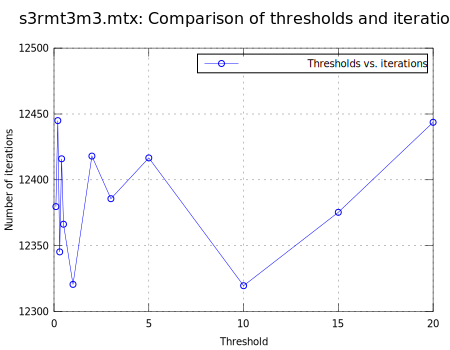

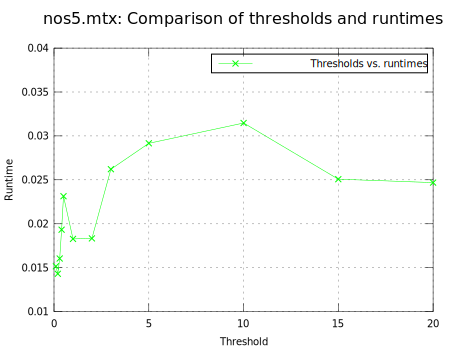

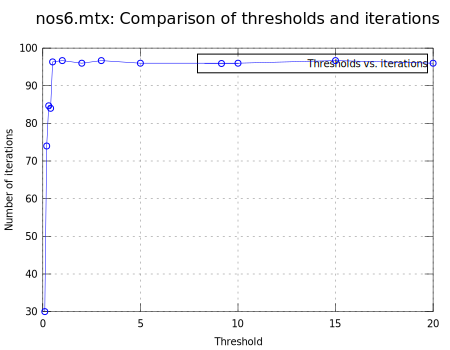

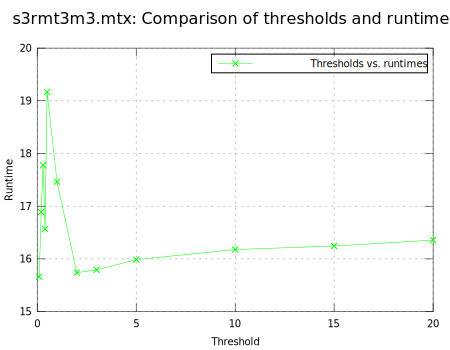

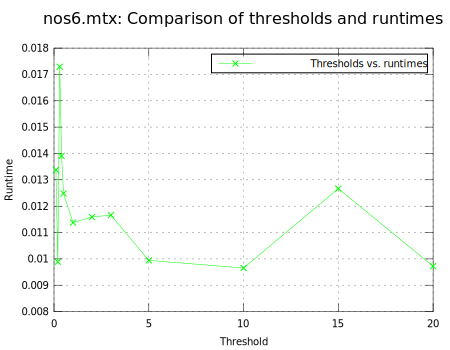

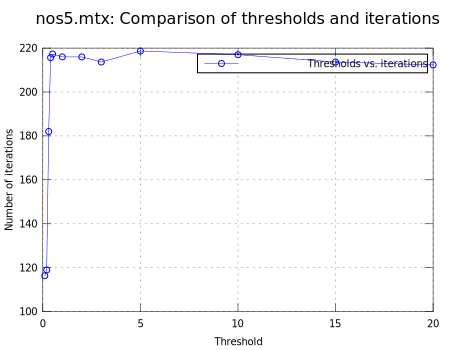

In [5]:
%plot -f svg

% Import routines needed to execute assignment.
source("source/assignment3.m")
% Import routines for reading matrix market (.mtx) format.
% Source: https://math.nist.gov/MatrixMarket/mmio/matlab/mmiomatlab.html.
source("source/mminfo.m")
source("source/mmread.m")

% Execute parameter grid/line search to find decent values for alpha, block size and dropping threshold.
% Note that search is variant towards the investigated PC method.
executeParameterGridSearch()